In [1]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
import cv2
import numpy as np

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

In [2]:
gym.register_envs(ale_py)
env = gym.make("ALE/Pong-v5", frameskip=5, render_mode="rgb_array")

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


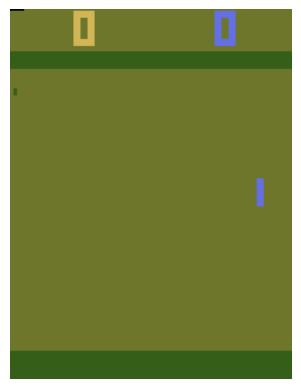

In [3]:
frame = env.reset()
img = env.render()  # returns an RGB array
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
class AtariPreprocessingWrapper(gym.Wrapper):
    def __init__(self, env, input_shape=(4, 84, 84)):
        super(AtariPreprocessingWrapper, self).__init__(env)
        self.input_shape = input_shape
        self.stacked_frames = np.zeros(self.input_shape, dtype=np.uint8)
        # Update the observation_space to match the preprocessed output
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=self.input_shape, dtype=np.uint8
        )

    def preprocess_frame(self, screen, exclude, output):
        screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
        screen = cv2.resize(screen, (output, output), interpolation=cv2.INTER_AREA)
        screen = np.ascontiguousarray(screen, dtype=np.uint8)
        return screen

    def stack_frame(self, stacked_frames, frame, is_new):
        if is_new:
            stacked_frames = np.stack([frame] * 4, axis=0)
        else:
            stacked_frames[:-1] = stacked_frames[1:]
            stacked_frames[-1] = frame
        return stacked_frames

    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        frame = self.preprocess_frame(state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=True)
        return self.stacked_frames, info

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        frame = self.preprocess_frame(next_state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=False)
        return self.stacked_frames, reward, terminated, truncated, info

In [5]:
env_ = AtariPreprocessingWrapper(env)

In [6]:
print(env_.observation_space)

Box(0, 255, (4, 84, 84), uint8)


In [7]:
# After resetting the environment
obs, info = env_.reset()
print("Shape:", obs.shape)        # Should be (4, 84, 84)
print("Dtype:", obs.dtype)        # Should be float32
print("Min/Max:", obs.min(), obs.max())  # Should be between 0.0 and 1.0

Shape: (4, 84, 84)
Dtype: uint8
Min/Max: 64 179


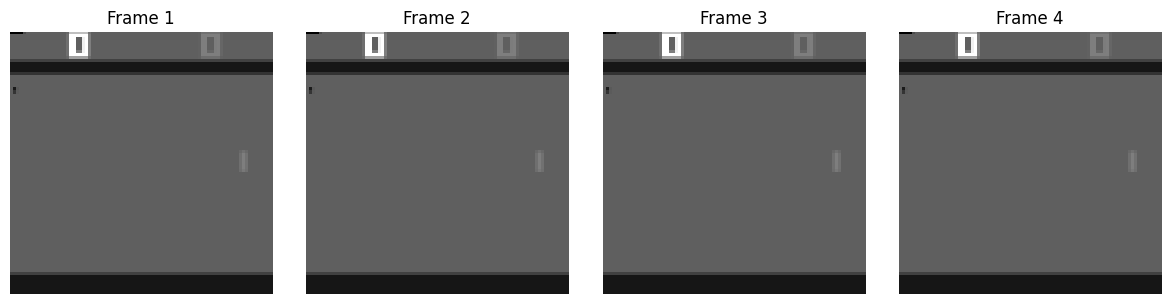

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(obs[i], cmap='gray')
    axs[i].set_title(f'Frame {i+1}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [9]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

def make_env():
    gym.register_envs(ale_py)
    env = gym.make("ALE/Pong-v5", frameskip=5, render_mode="rgb_array")
    env = AtariPreprocessingWrapper(env)
    return env

def optimize_ppo(trial):
    env = make_env()
    eval_env = make_env()

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    n_steps = trial.suggest_categorical('n_steps', [128, 256, 512, 1024])
    gamma = trial.suggest_float('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_float('gae_lambda', 0.8, 0.99)
    clip_range = trial.suggest_float('clip_range', 0.1, 0.3)
    ent_coef = trial.suggest_float('ent_coef', 1e-8, 1e-2, log=True)

    model = PPO(
        "CnnPolicy",
        env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
        verbose=1,
        device="cuda"  # Enable this if using GPU
    )

    model.learn(total_timesteps=150_000)
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=2)
    return mean_reward

# Start the Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=6)

print("Best hyperparameters:", study.best_params)


[I 2025-06-25 14:29:09,751] A new study created in memory with name: no-name-79faf82c-122e-45ca-b7ba-fe83ee0efccc


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 155 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 256 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 159         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 512         |
| train/                  |             |
|    approx_kl            | 0.017940674 |
|    clip_fraction        | 0.0336      |
|    clip_range           | 0.232       |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.0181      |
|    learning_rate        | 0.000117    |
|    loss                 | 0.0353      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0077     |
|    value_loss           | 0.

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2025-06-25 14:35:22,819] Trial 0 finished with value: -21.0 and parameters: {'learning_rate': 0.00011677344059985818, 'n_steps': 256, 'gamma': 0.9587441844357083, 'gae_lambda': 0.8777921470730469, 'clip_range': 0.23151208431514414, 'ent_coef': 0.00011307252882867835}. Best is trial 0 with value: -21.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 377 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 844          |
|    ep_rew_mean          | -19          |
| time/                   |              |
|    fps                  | 316          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0062591955 |
|    clip_fraction        | 0.0816       |
|    clip_range           | 0.145        |
|    entropy_loss         | -1.79        |
|    explained_variance   | -0.00406     |
|    learning_rate        | 0.000401     |
|    loss     

[I 2025-06-25 14:41:36,795] Trial 1 finished with value: -16.0 and parameters: {'learning_rate': 0.0004013191881325737, 'n_steps': 512, 'gamma': 0.9639452167810578, 'gae_lambda': 0.8274033895133379, 'clip_range': 0.1445217331955355, 'ent_coef': 2.177738835326187e-05}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 391 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 612           |
|    ep_rew_mean          | -21           |
| time/                   |               |
|    fps                  | 321           |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00028573594 |
|    clip_fraction        | 0             |
|    clip_range           | 0.241         |
|    entropy_loss         | -1.79         |
|    explained_variance   | -0.00539      |
|    learning_rate        | 1.07e-05      

[I 2025-06-25 14:47:46,307] Trial 2 finished with value: -21.0 and parameters: {'learning_rate': 1.0710625290356293e-05, 'n_steps': 512, 'gamma': 0.9603927905620662, 'gae_lambda': 0.9513056564962502, 'clip_range': 0.24078025341840414, 'ent_coef': 1.7441870062148978e-08}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 711      |
|    ep_rew_mean     | -20      |
| time/              |          |
|    fps             | 397      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 722         |
|    ep_rew_mean          | -20         |
| time/                   |             |
|    fps                  | 324         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.003615525 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.115       |
|    entropy_loss  

[I 2025-06-25 14:53:59,075] Trial 3 finished with value: -21.0 and parameters: {'learning_rate': 9.737704407345521e-05, 'n_steps': 1024, 'gamma': 0.9225951719268555, 'gae_lambda': 0.8743239989452538, 'clip_range': 0.11484388414112552, 'ent_coef': 0.005587499889710052}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 395 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 797         |
|    ep_rew_mean          | -20         |
| time/                   |             |
|    fps                  | 322         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.015722893 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.235       |
|    entropy_loss         | -1.78       |
|    explained_variance   | -0.0128     |
|    learning_rate        | 4.32e-05    |
|    loss                 | 0.

[I 2025-06-25 15:00:07,141] Trial 4 finished with value: -21.0 and parameters: {'learning_rate': 4.3236649230794157e-05, 'n_steps': 512, 'gamma': 0.9406321580398679, 'gae_lambda': 0.8231636883935916, 'clip_range': 0.23548071279989835, 'ent_coef': 0.0016961116672533875}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 843      |
|    ep_rew_mean     | -19      |
| time/              |          |
|    fps             | 376      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 814         |
|    ep_rew_mean          | -19         |
| time/                   |             |
|    fps                  | 316         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008613995 |
|    clip_fraction        | 0           |
|    clip_range           | 0.217       |
|    entropy_loss  

[I 2025-06-25 15:06:15,936] Trial 5 finished with value: -21.0 and parameters: {'learning_rate': 2.76521896716131e-05, 'n_steps': 1024, 'gamma': 0.9861964892288216, 'gae_lambda': 0.8366034847588224, 'clip_range': 0.21701320173979932, 'ent_coef': 1.5373059525411305e-08}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 394 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 128 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 329          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0009857197 |
|    clip_fraction        | 0            |
|    clip_range           | 0.227        |
|    entropy_loss         | -1.79        |
|    explained_variance   | 0.00784      |
|    learning_rate        | 4.46e-05     |
|    loss                 | 0.0258       |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0041      |
|    value_los

[I 2025-06-25 15:12:18,898] Trial 6 finished with value: -21.0 and parameters: {'learning_rate': 4.464632744858413e-05, 'n_steps': 128, 'gamma': 0.9755305045039593, 'gae_lambda': 0.9422517358793921, 'clip_range': 0.22687083597156868, 'ent_coef': 5.172914445716745e-07}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 398 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 641         |
|    ep_rew_mean          | -21         |
| time/                   |             |
|    fps                  | 323         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.025346316 |
|    clip_fraction        | 0.0998      |
|    clip_range           | 0.271       |
|    entropy_loss         | -1.78       |
|    explained_variance   | -0.000235   |
|    learning_rate        | 0.000464    |
|    loss                 | 0.

[I 2025-06-25 15:18:32,584] Trial 7 finished with value: -17.5 and parameters: {'learning_rate': 0.0004639192239536669, 'n_steps': 512, 'gamma': 0.9014619087393965, 'gae_lambda': 0.986477050931982, 'clip_range': 0.2709258073301618, 'ent_coef': 1.2764310738960555e-05}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 690      |
|    ep_rew_mean     | -20      |
| time/              |          |
|    fps             | 395      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 1024     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 662         |
|    ep_rew_mean          | -20.7       |
| time/                   |             |
|    fps                  | 326         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.014772271 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.214       |
|    entropy_loss  

[I 2025-06-25 15:24:45,976] Trial 8 finished with value: -16.0 and parameters: {'learning_rate': 0.00012121985152686752, 'n_steps': 1024, 'gamma': 0.9309884418389816, 'gae_lambda': 0.8954247915050677, 'clip_range': 0.21355790602856178, 'ent_coef': 1.5974691479705305e-06}. Best is trial 1 with value: -16.0.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 391 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 697         |
|    ep_rew_mean          | -21         |
| time/                   |             |
|    fps                  | 322         |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.026726864 |
|    clip_fraction        | 0.0414      |
|    clip_range           | 0.242       |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.0123      |
|    learning_rate        | 7.19e-05    |
|    loss                 | 0.

[I 2025-06-25 15:30:54,871] Trial 9 finished with value: -21.0 and parameters: {'learning_rate': 7.190882041570484e-05, 'n_steps': 512, 'gamma': 0.9943743011964942, 'gae_lambda': 0.8799451186176211, 'clip_range': 0.24159821574039902, 'ent_coef': 0.00028639176468642284}. Best is trial 1 with value: -16.0.


Best hyperparameters: {'learning_rate': 0.0004013191881325737, 'n_steps': 512, 'gamma': 0.9639452167810578, 'gae_lambda': 0.8274033895133379, 'clip_range': 0.1445217331955355, 'ent_coef': 2.177738835326187e-05}


In [7]:
from stable_baselines3 import PPO

# Use your best hyperparameters from Optuna
model_PPO = PPO(
    "CnnPolicy",
    env_,
    learning_rate=0.0004013191881325737,
    n_steps=512,
    gamma=0.9639452167810578,
    gae_lambda=0.8274033895133379,
    clip_range=0.1445217331955355,
    ent_coef=2.177738835326187e-05,
    verbose=1,
    device="cuda",
    tensorboard_log="./tensorboard_log"
    
)

model_PPO.learn(total_timesteps=500_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log/PPO_1
----------------------------
| time/              |     |
|    fps             | 224 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 808         |
|    ep_rew_mean          | -21         |
| time/                   |             |
|    fps                  | 216         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.004316313 |
|    clip_fraction        | 0.0104      |
|    clip_range           | 0.145       |
|    entropy_loss         | -1.79       |
|    explained_variance   | -0.00122    |
|    learning_rate        | 0.000401 

In [8]:
def run_episodes_log_behavior(model, env, n_episodes=10):
    episode_logs = []
    for episode in range(n_episodes):
        obs, info = env.reset()
        done = False
        episode_data = {"actions": [], "rewards": [], "frames": []}
        total_reward = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            episode_data["actions"].append(int(action))
            
            obs, reward, terminated, truncated, info = env.step(action)
            episode_data["rewards"].append(reward)
            episode_data["frames"].append(obs[-1])  # last frame in stack
            
            total_reward += reward
            done = terminated or truncated
        
        episode_data["total_reward"] = total_reward
        episode_data["episode_length"] = len(episode_data["actions"])
        episode_logs.append(episode_data)
        print(f"Episode {episode+1}: Reward = {total_reward:.2f}, Length = {episode_data['episode_length']}")
        
    return episode_logs

In [9]:
# Evaluate
episodes = 1000
episode_logs = run_episodes_log_behavior(model_PPO, env_, n_episodes=episodes)

Episode 1: Reward = -12.00, Length = 1837
Episode 2: Reward = -13.00, Length = 1560
Episode 3: Reward = -12.00, Length = 1743
Episode 4: Reward = -13.00, Length = 1697
Episode 5: Reward = -20.00, Length = 1755
Episode 6: Reward = -17.00, Length = 1553
Episode 7: Reward = -12.00, Length = 1781
Episode 8: Reward = -9.00, Length = 1869
Episode 9: Reward = -16.00, Length = 1642
Episode 10: Reward = -15.00, Length = 1546
Episode 11: Reward = -12.00, Length = 1709
Episode 12: Reward = -12.00, Length = 1791
Episode 13: Reward = -13.00, Length = 2023
Episode 14: Reward = -14.00, Length = 1600
Episode 15: Reward = -15.00, Length = 1591
Episode 16: Reward = -11.00, Length = 1848
Episode 17: Reward = -17.00, Length = 1533
Episode 18: Reward = -18.00, Length = 1599
Episode 19: Reward = -11.00, Length = 1793
Episode 20: Reward = -18.00, Length = 1533
Episode 21: Reward = -11.00, Length = 1900
Episode 22: Reward = -13.00, Length = 1794
Episode 23: Reward = -12.00, Length = 1753
Episode 24: Reward = 

In [14]:
def plot_reward_trend(episode_logs, window_size=10):
    episode_rewards = [ep["total_reward"] for ep in episode_logs]
    if len(episode_rewards) < window_size:
        window_size = len(episode_rewards)  
    
    rolling_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(range(window_size - 1, len(episode_rewards)), rolling_avg, label=f'{window_size}-Episode Moving Average', color='red')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Trend Over Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()

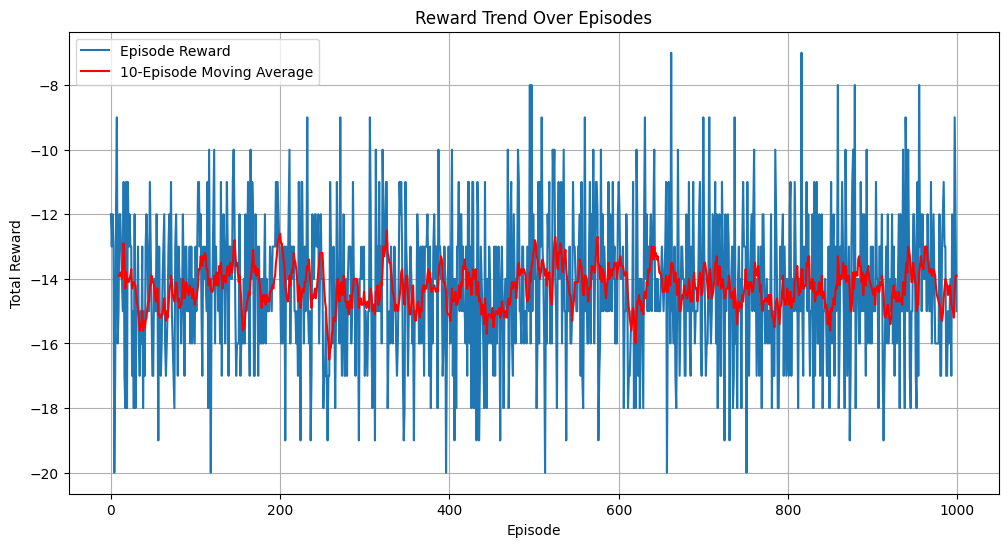

In [15]:
plot_reward_trend(episode_logs)

In [16]:
def plot_action_distribution(episode_logs, env):
    # Collect all actions taken in all episodes
    all_actions = [action for ep in episode_logs for action in ep["actions"]]

    plt.figure(figsize=(10, 5))
    plt.hist(all_actions, bins=np.arange(0, env.action_space.n + 1) - 0.5, edgecolor='black')
    plt.title("Action Distribution Across All Episodes")
    plt.xlabel("Action")
    plt.ylabel("Count")
    plt.xticks(range(env.action_space.n))
    plt.grid(True)
    plt.show()

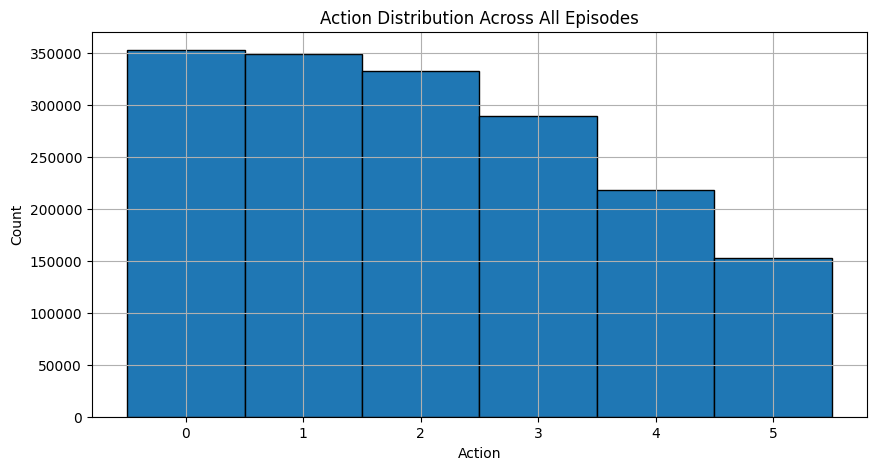

In [17]:
plot_action_distribution(episode_logs, env_)

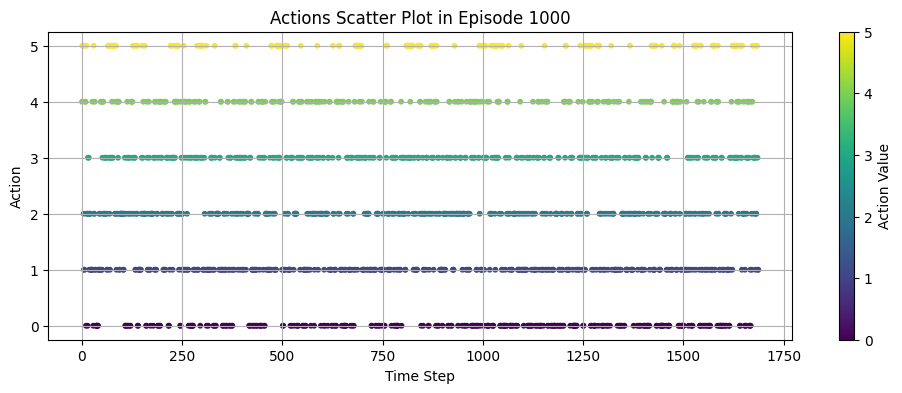

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_plot_actions(actions, episode=0):
    """
    Scatter plot of actions taken over time steps in a single episode.

    actions: List of lists, each inner list contains actions from one episode.
    episode: index of the episode to plot
    """
    episode_actions = actions[episode]

    plt.figure(figsize=(12, 4))
    plt.scatter(range(len(episode_actions)), episode_actions, c=episode_actions, cmap="viridis", s=10)
    plt.xlabel("Time Step")
    plt.ylabel("Action")
    plt.title(f"Actions Scatter Plot in Episode {episode + 1}")
    plt.yticks(np.unique(episode_actions))
    plt.colorbar(label='Action Value')
    plt.grid(True)
    plt.show()

# Assuming you have episode_logs from your run_episodes_log_behavior function
actions_ppo = [ep["actions"] for ep in episode_logs]

# Plot for first episode
scatter_plot_actions(actions_ppo, episode=999)

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_action_usage_over_time(episode_logs, chunk_size=50, env=None):
    n_chunks = len(episode_logs) // chunk_size
    action_counts = []
    
    for i in range(n_chunks):
        chunk_actions = [a for ep in episode_logs[i*chunk_size:(i+1)*chunk_size] for a in ep["actions"]]
        counts, _ = np.histogram(chunk_actions, bins=np.arange(env.action_space.n + 1))
        action_counts.append(counts)
    
    action_counts = np.array(action_counts)
    
    plt.figure(figsize=(12,6))
    for action in range(action_counts.shape[1]):
        plt.plot(range(n_chunks), action_counts[:, action], label=f"Action {action}")
    plt.xlabel(f"Episode chunks (size={chunk_size})")
    plt.ylabel("Action count")
    plt.title("Action Usage Over Training")
    plt.legend()
    plt.grid(True)
    plt.show()

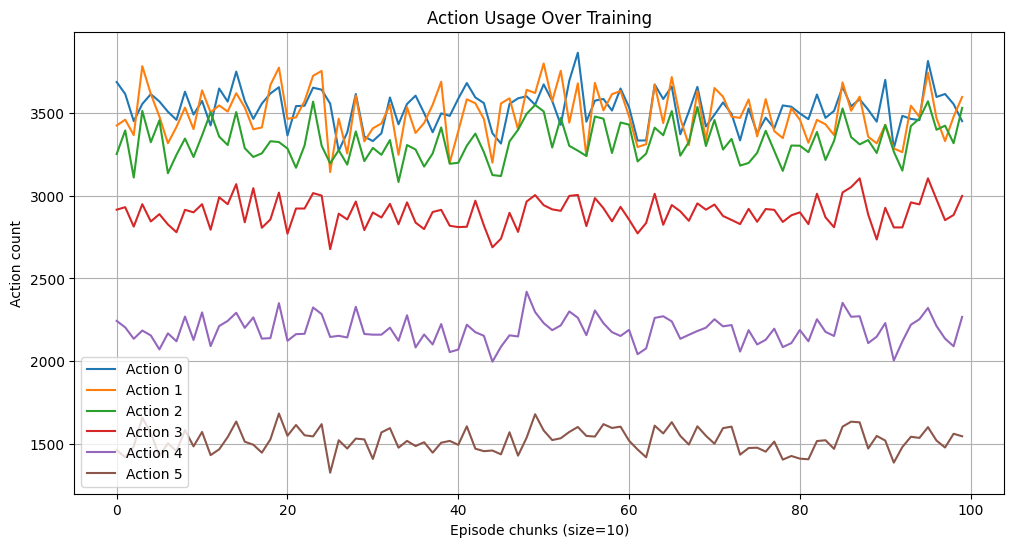

In [28]:
plot_action_usage_over_time(episode_logs, chunk_size=10, env=env_)

In [25]:
def plot_episode_lengths(episode_logs):
    lengths = [len(ep["actions"]) for ep in episode_logs]
    plt.figure(figsize=(10,5))
    plt.plot(lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length (timesteps)")
    plt.title("Episode Length over Time")
    plt.grid(True)
    plt.show()

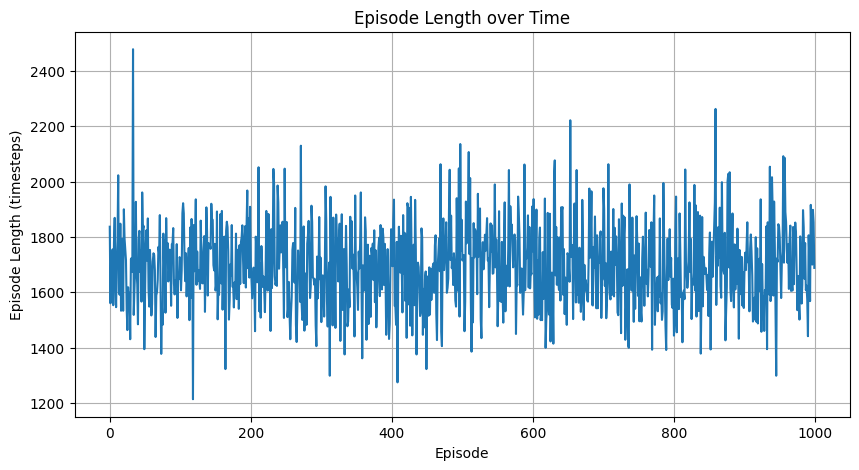

In [26]:
plot_episode_lengths(episode_logs)